# Two-Sample K-S Test

In [25]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm
from scipy.stats import ks_2samp
from tqdm import tqdm

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

## Import Data

In [26]:
df_day = pd.read_csv('day.csv')

In [27]:
df_day_spring = df_day[df_day['season']==2].copy()
df_day_summer = df_day[df_day['season']==3].copy()

## Data Exploration

### 1. Duplicated Values

In [28]:
print('Spring:')
print('There are',
      len(df_day_spring['cnt']),
      'samples in total.')
print('There are',
      len(df_day_spring['cnt'].unique()),
      'unique sample values.')
print('Duplicated values: ',
      len(df_day_spring['cnt']) - len(df_day_spring['cnt'].unique()))

Spring:
There are 184 samples in total.
There are 182 unique sample values.
Duplicated values:  2


In [29]:
print('Summer:')
print('There are',
      len(df_day_summer['cnt']),
      'samples in total.')
print('There are',
      len(df_day_summer['cnt'].unique()),
      'unique sample values.')
print('Duplicated values: ',
      len(df_day_summer['cnt']) - len(df_day_summer['cnt'].unique()))

Summer:
There are 188 samples in total.
There are 188 unique sample values.
Duplicated values:  0


**`Comments`**

1. There are **only 2 duplicate values** which is fairly small compare to the sample sizes.
2. These 2 duplicated values will not have significant effects on the **empirical cumulative functions** of the samples (can be **ignored**).
2. We can say that our samples are **roughly ordinal** and therefore suitable to carry out the K-S test.

### 2. Key Statistics

In [30]:
print('Spring:')
df_day_spring['cnt'].describe()

Spring:


count     184.000000
mean     4992.331522
std      1695.977235
min       795.000000
25%      4003.000000
50%      4941.500000
75%      6377.000000
max      8362.000000
Name: cnt, dtype: float64

In [31]:
print('Summer:')
df_day_summer['cnt'].describe()

Summer:


count     188.000000
mean     5644.303191
std      1459.800381
min      1115.000000
25%      4586.500000
50%      5353.500000
75%      6929.250000
max      8714.000000
Name: cnt, dtype: float64

**`Comments`**

1. Spring has a **lower mean daily bike usage** of around **4992** and a **larger standard deviation** of around **1696**.
2. Summer has a **higher** mean daily bike usage of around **5644** and a **smaller** standard deviation of around **1460**.
3. Suggesting the two distributions might have **differnt peak positions and spreads**.

### 3. Distributions

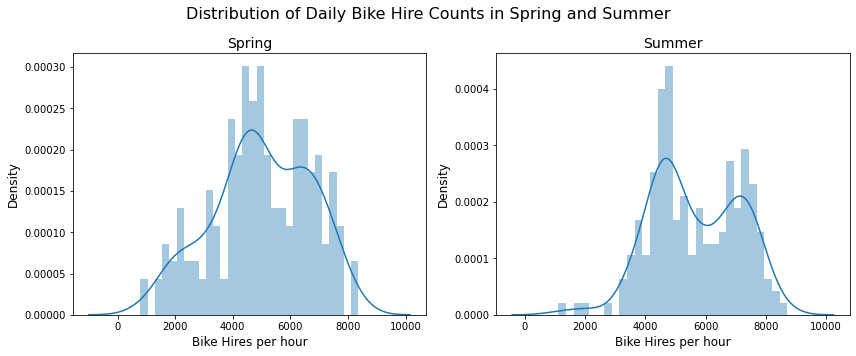

In [9]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.distplot(df_day[df_day['season']==2]['cnt'], bins=30)
plt.title('Spring', fontsize=14)
plt.ylabel('Density', fontsize=12)
plt.xlabel('Bike Hires per hour', fontsize=12)

plt.subplot(1, 2, 2)
sns.distplot(df_day[df_day['season']==3]['cnt'], bins=30)
plt.title('Summer', fontsize=14)
plt.ylabel('Density', fontsize=12)
plt.xlabel('Bike Hires per hour', fontsize=12)

fig.suptitle('Distribution of Daily Bike Hire Counts in Spring and Summer', fontsize=16)
plt.tight_layout()
plt.show()

**`Comments`**

1. Spring has a larger standard deviation, thus, **thicker tails**.
2. Similarity: both have a **slightly lower peak** to the right of the main peak.

## Continuous K-S Test

In [9]:
def continuous_KS(A, B, alpha):
    results = ks_2samp(A, B)
    d = results[0]
    p_value = results[1]
    
    n, m = len(A), len(B)
    D_critical = np.sqrt(-0.5*np.log(alpha)*(n+m)/(n*m))
    
    print('The significance level of the test is: ', alpha)
    print(f'The observed test statistic is: {round(d,8)}')
    print('The two-sided critical value of the test statistic D at the level of 5% is: ', round(D_critical, 8))
    print(f'The two-sided p-value is: {round(p_value,8)}')
    print()

## Discrete K-S Test

In [10]:
def discrete_KS(A, B, alpha, permutation_size): 
    
    #compute the observed value of test statistic D from the samples
    samples = np.append(A,B)
    samples = sorted(samples)
    freq_A, freq_B = [], []
    for x in samples:
        freq_A.append(len([sample for sample in A if sample <=x])/len(A))
        freq_B.append(len([sample for sample in B if sample <=x])/len(B))
    d = max(abs(np.array(freq_A)-np.array(freq_B)))
    idx = np.argmax(abs(np.array(freq_A)-np.array(freq_B)))
    
    #plot the empirical cumulative distribution functions of the two samples
    fig = plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.plot(sorted(samples), freq_A, label='Spring')
    plt.plot(sorted(samples), freq_B, label='Summer')
    plt.axvline(x=samples[idx], ymin=freq_B[idx]+0.036, ymax=freq_A[idx]+0.01, color='r', label='observed statistic')
    plt.title('Empirical Cumulative Distribution Functions', fontsize=15)
    plt.ylabel('Probability', fontsize=12)
    plt.xlabel('Bike Usage', fontsize=12)
    plt.legend() 
    
    #simulation using permutation tests
    np.random.seed(0)
    samples = np.append(A, B)
    D_list = []
    for _ in tqdm(range(permutation_size)):
        perm_samples = np.random.permutation(samples)
        new_A, new_B = perm_samples[:len(A)], perm_samples[len(A):]
        freq_A, freq_B = [], []
        for x in samples:
            freq_A.append(len([sample for sample in new_A if sample <=x])/len(A))
            freq_B.append(len([sample for sample in new_B if sample <=x])/len(B))
        D = max(abs(np.array(freq_A)-np.array(freq_B)))
        D_list.append(D)
    D_critical = sorted(D_list)[round((1-alpha/2)*len(D_list))]
    p_value = len([x for x in D_list if x > d]) / len(D_list)
    
    #print the test information and results
    print('The significance level of the test is: ', alpha)
    print(f'The observed test statistic is: {round(d,8)}')
    print('The two-sided critical value of the test statistic D at the level of 5% is: ', round(D_critical, 8))
    print(f'The two-sided p-value is: {round(p_value,8)}')
    print()
    
    #plot the distribution of the test statistic D
    plt.subplot(1,2,2)
    sns.distplot(D_list, bins=20)
    plt.axvline(d, color='r', label='Observed D')
    plt.title('Distribution of the Test Statistic D', fontsize=15)
    plt.legend()
    plt.show()

## Results

In [11]:
alpha = 0.05
n_permutation = 500

A = df_day_spring['cnt']
B = df_day_summer['cnt']

In [12]:
continuous_KS(A, B, alpha)

The significance level of the test is:  0.05
The observed test statistic is: 0.18223867
The two-sided critical value of the test statistic D at the level of 5% is:  0.1269171
The two-sided p-value is: 0.00344077



**`Comments`**

1. The **observed statistic** 0f 0.1822 is larger than the critical value of 0.1269.
2. the **p-value** of 0.3% is smaller than the significance level of 5%.
3. Thus: the null hypothesis is rejected at 5%.

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.17it/s]


The significance level of the test is:  0.05
The observed test statistic is: 0.18223867
The two-sided critical value of the test statistic D at the level of 5% is:  0.15124884
The two-sided p-value is: 0.006



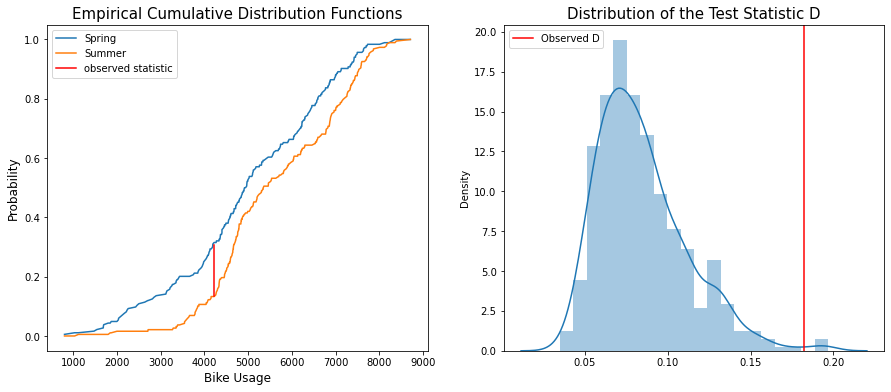

In [13]:
discrete_KS(A, B, alpha, n_permutation)

**`Comments`**

1. The **critical value** found from **permutation** is around 0.1512 which is slightly larger than the one calculated using formula.
2. The **observed statistic** is still larger that the found critical value.
3. The **p-value** of 0.6% is **twice** of that computed in the continuous case but still much smaller than the significance level.
4. Thus: the null hypothesis is rejected.